In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Load the data

In [37]:
df = pd.read_csv('data/interim/final_paths_ordered.csv')
df

,Level 1,Level 2,Level 3,Level 4,Level 5,Level 6,Level 7,Relative Strength
0,______,A_____,AA____,AAT___,AATT__,AATTT_,AATTTA,0.1190
1,______,A_____,AA____,AAT___,AATT__,AATT_T,AATTCT,0.1175
2,______,A_____,AA____,AAT___,AAT_C_,AATTC_,AATTCA,0.1068
3,______,A_____,AA____,AA_T__,AA_TT_,AA_TTA,AACTTA,0.1186
4,______,A_____,AA____,AA__C_,AA__CC,AAA_CC,AAATCC,0.1145
...,...,...,...,...,...,...,...,...
4091,______,_____T,____TT,_C__TT,_C_GTT,_CAGTT,CCAGTT,0.0814
4092,______,_____T,____TT,__C_TT,G_C_TT,GCC_TT,GCCATT,0.1043
4093,______,_____T,____TT,__C_TT,G_C_TT,G_CTTT,GTCTTT,0.1011
4094,______,_____T,____TT,__C_TT,_CC_TT,CCC_TT,CCCATT,0.1098


## Remove the Level 1 and (optionally) set some minimal threshold for the Relative Strength or other filters

In [38]:
THRESHOLD = 0.25
df = df.drop(columns=['Level 1'])
# df = df[df['Relative Strength'] >= THRESHOLD]

## One-hot encoding

### Encode the sequences

In [39]:
# Define the characters used
characters = ['A', 'C', 'G', 'T', '_']

# Function to one-hot encode a single sequence
def one_hot_encode(sequence, characters):
    char_to_int = dict((c, i) for i, c in enumerate(characters))
    integer_encoded = [char_to_int[char] for char in sequence]
    onehot_encoded = []
    for value in integer_encoded:
        letter = [0 for _ in range(len(characters))]
        letter[value] = 1
        onehot_encoded.append(letter)
    return np.array(onehot_encoded).flatten()

# Apply the encoding to each column in the dataframe and preserve column names
encoded_columns = []
for col in df.columns[:-1]:  # Exclude 'Relative Strength' column for encoding
    encoded_sequences = df[col].apply(lambda x: one_hot_encode(x, characters))
    col_encoded_df = pd.DataFrame(encoded_sequences.tolist(), columns=[f"{col}_{i}" for i in range(encoded_sequences.iloc[0].size)])
    encoded_columns.append(col_encoded_df)

# Concatenate all encoded columns into a single dataframe
encoded_df = pd.concat(encoded_columns, axis=1)

### Encode the relative strength value

In [40]:
# Add index as a column for clustering
encoded_df['index'] = df.index
encoded_df['Relative Strength'] = df['Relative Strength']

# Encode the relative strength
NUMBER_OF_COLUMNS_FOR_STRENGTH = 200

# Function to convert a value to a binary list with 200 columns
def value_to_binary_list(value, length=NUMBER_OF_COLUMNS_FOR_STRENGTH):
    ones_count = int(round(value, 2) * NUMBER_OF_COLUMNS_FOR_STRENGTH)
    return [1] * ones_count + [0] * (length - ones_count)

# Apply the function to create binary columns
binary_columns = df['Relative Strength'].apply(value_to_binary_list)

# Create a DataFrame from the binary columns
binary_df = pd.DataFrame(binary_columns.tolist(), columns=[f'rel_strength_{i+1}' for i in range(NUMBER_OF_COLUMNS_FOR_STRENGTH)])

encoded_df = pd.concat([encoded_df, binary_df], axis=1)

encoded_df

,Level 2_0,Level 2_1,Level 2_2,Level 2_3,Level 2_4,Level 2_5,Level 2_6,Level 2_7,Level 2_8,Level 2_9,...,rel_strength_191,rel_strength_192,rel_strength_193,rel_strength_194,rel_strength_195,rel_strength_196,rel_strength_197,rel_strength_198,rel_strength_199,rel_strength_200
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4092,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4093,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4094,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Perform the PLS

In [41]:
# Identify columns to drop that start with "rel_strength"
columns_to_drop = [col for col in encoded_df.columns if col.startswith('rel_strength')]

# Explicitly add 'Relative Strength' to the list of columns to drop
columns_to_drop.append('Relative Strength')

# Drop the identified columns
X = encoded_df.drop(columns=columns_to_drop)

y = encoded_df['Relative Strength']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the PLS regression model
pls = PLSRegression(n_components=4)  # Number of components can be tuned
pls.fit(X_train, y_train)

# Predict on the test set
y_pred = pls.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Get the PLS coefficients
pls_coefficients = pls.coef_

# Reshape coefficients array for DataFrame creation
coefficients_1d = pls_coefficients.flatten()

# Create DataFrame with coefficients
coefficients_df = pd.DataFrame(coefficients_1d, index=X.columns, columns=['Coefficient'])

# Sort coefficients by absolute value
coefficients_df_abs = coefficients_df.abs().sort_values(by='Coefficient', ascending=False)

# Display the top influential coefficients
coefficients_df_abs.head(10)

Mean Squared Error: 0.018914216912832925


,Coefficient
Level 2_1,0.122698
Level 2_8,0.093357
Level 3_10,0.089104
Level 2_11,0.068023
Level 3_17,0.067265
Level 3_23,0.060395
Level 3_12,0.054853
Level 2_12,0.049945
Level 3_5,0.048548
Level 2_15,0.048186


## Interpret the coefficients from PLS

In [42]:
# Function to interpret coefficients back to sequence positions
def interpret_coefficients(coefficients_df, characters):
    interpreted_coefficients = []
    for index, row in coefficients_df.iterrows():
        parts = index.split('_')
        if len(parts) < 2:
            continue  # Skip if the index format is not as expected
        column_name = parts[0]
        position = int(parts[1]) // len(characters)  # Calculate position in the sequence
        character_index = int(parts[1]) % len(characters)  # Determine which character
        character = characters[character_index]
        interpreted_coefficients.append((column_name, position, character, row['Coefficient']))
    return interpreted_coefficients

# Interpret coefficients
interpreted_coefficients = interpret_coefficients(coefficients_df_abs, characters)

# Create a DF from the interpreted coefficients
coeff_data = []

for item in interpreted_coefficients:
    coeff_data.append({'level': item[0].split(' ')[1], 'position': item[1] + 1, 'character': item[2], 'coefficient': round(item[3], 4)})

df_coefficients = pd.DataFrame(coeff_data)
df_coefficients

,level,position,character,coefficient
0,2,1,C,0.1227
1,2,2,T,0.0934
2,3,3,A,0.0891
3,2,3,C,0.0680
4,3,4,G,0.0673
...,...,...,...,...
175,7,2,_,0.0000
176,7,3,_,0.0000
177,7,4,_,0.0000
178,7,5,_,0.0000


In [43]:
# Get the number of non-zero coefficients
non_zero_coefficients = len(df_coefficients[df_coefficients['coefficient'] != 0])
print(f'Number of non-zero coefficients: {non_zero_coefficients} / {len(df_coefficients)}')

Number of non-zero coefficients: 174 / 180


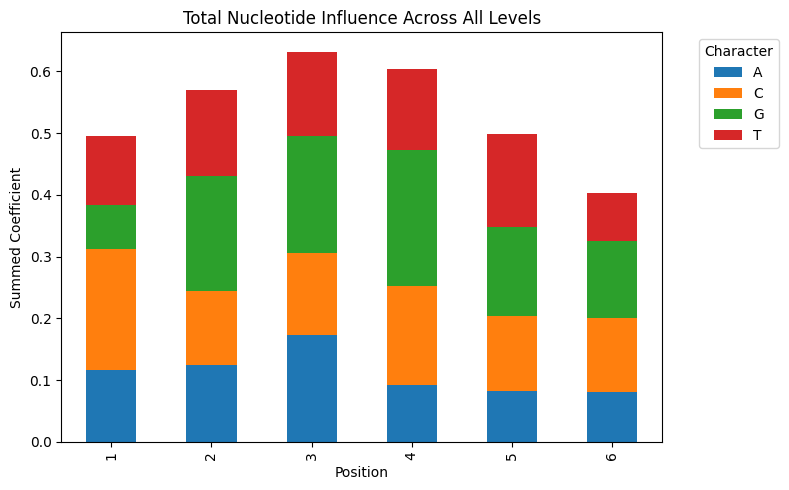

In [44]:
# Aggregate across all levels: sum coefficients by position & character
agg = df_coefficients.groupby(['position', 'character'])['coefficient'].sum().reset_index()

# Remove the _ character from the agg dataset
agg = agg[agg['character'] != '_']

# Pivot so each position is a row, characters are columns
pivot = agg.pivot_table(
    index='position',
    columns='character',
    values='coefficient',
    fill_value=0,
)

# Plot a single stacked‐bar chart
fig, ax = plt.subplots(figsize=(8, 5))
pivot.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Total Nucleotide Influence Across All Levels')
ax.set_xlabel('Position')
ax.set_ylabel('Summed Coefficient')
ax.legend(title='Character', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()